# Part - II: Data Analysis, ML and NN models

The dataset selected in this assignment is 'Hourly Meteorological Data and Ozone Concentration'. We have the following columns- 

1) SITE_ID: Unique station/site identifier (e.g., ABT147). - Will be mapped to site name for readability

2) DATEON: Timestamp when the measurement was recorded (hourly).

3) Ozone: Ozone concentration measured at the site (measured in ppb).

4) Temperature: Ambient air temperature at the site (degrees Celsius).

5) Shelter Temperature: Temperature inside the instrument enclosure (degrees Celsius).

6) Relative Humidity: Ambient relative humidity (%).

7) Wind Speed: Wind speed (metres/sec).

8) Wind Direction: Wind direction (degrees 0–360).

9) Solar Radiation: Solar irradiance (Watts/m²).

10) Precipitation: Rainfall amount (mm per hour).

11) Wetness: surface wetness sensor or wetness indicator (percentage fraction, 0.00-1.00).

12) Flow Rate: Instrument/sample flow rate (litres/min).


This timestep data shall be used to predict ozone concentration at a given time-step in the future.

Note: We shall be taking top 5 most complete sites as some data is missing in a lot of sites.

In [335]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [232]:
DATA_DIR = Path('d:\\Dev\\Deep Learning Coursework\\Assignment 0\\Project/data/')
MAIN_CSV_path = DATA_DIR / 'Main_met_data.csv'
SITE_CSV_path = DATA_DIR / 'Site_names.xlsx'

In [233]:
#Loading Data

if Path.exists(MAIN_CSV_path) and Path.exists(SITE_CSV_path):
    main_df = pd.read_csv(MAIN_CSV_path, na_values=["-", " -", "- ", ""], keep_default_na=True)
    site_df = pd.read_excel(SITE_CSV_path, na_values=["-", " -", "- ", ""], keep_default_na=True)
    print("Data files loaded successfully.")
else:
    print("Data files not found. Please check the paths.")

Data files loaded successfully.


In [234]:
MAIN_CSV_path

WindowsPath('d:/Dev/Deep Learning Coursework/Assignment 0/Project/data/Main_met_data.csv')

In [235]:
# Shape + columns
print("Rows, Cols:", main_df.shape)
print("Columns:", main_df.columns.tolist())

# First/last few rows
display(main_df.head(10))
display(main_df.tail(10))

# Random sample 
display(main_df.sample(10, random_state=42))

Rows, Cols: (365005, 12)
Columns: ['SITE_ID', 'Flow Rate', 'Precipitation', 'Ozone', 'Relative Humidity', 'Shelter Temperature', 'Solar Radiation', 'Temperature', 'Wetness', 'Wind Direction', 'Wind Speed', 'DATEON']


,SITE_ID,Flow Rate,Precipitation,Ozone,Relative Humidity,Shelter Temperature,Solar Radiation,Temperature,Wetness,Wind Direction,Wind Speed,DATEON
0,ABT147,1.496,NaN,30.87,NaN,24.90,NaN,13.59,NaN,NaN,NaN,5/26/2025 7:00:00 AM
1,ABT147,1.496,NaN,24.57,NaN,24.52,NaN,11.76,NaN,NaN,NaN,5/26/2025 6:00:00 AM
2,ABT147,1.496,NaN,22.17,NaN,25.08,NaN,9.74,NaN,NaN,NaN,5/26/2025 5:00:00 AM
3,ABT147,1.496,NaN,22.65,NaN,25.13,NaN,8.69,NaN,NaN,NaN,5/26/2025 4:00:00 AM
4,ABT147,1.496,NaN,23.83,NaN,24.93,NaN,9.13,NaN,NaN,NaN,5/26/2025 3:00:00 AM
5,ABT147,1.496,NaN,24.66,NaN,25.03,NaN,9.74,NaN,NaN,NaN,5/26/2025 2:00:00 AM
6,ABT147,1.496,NaN,24.12,NaN,24.99,NaN,9.62,NaN,NaN,NaN,5/26/2025 1:00:00 AM
7,ABT147,1.496,NaN,22.02,NaN,24.86,NaN,8.43,NaN,NaN,NaN,5/26/2025 12:00:00 AM
8,ABT147,1.496,NaN,24.73,NaN,24.94,NaN,9.42,NaN,NaN,NaN,5/25/2025 11:00:00 PM
9,ABT147,1.496,NaN,26.87,NaN,25.01,NaN,10.66,NaN,NaN,NaN,5/25/2025 10:00:00 PM


,SITE_ID,Flow Rate,Precipitation,Ozone,Relative Humidity,Shelter Temperature,Solar Radiation,Temperature,Wetness,Wind Direction,Wind Speed,DATEON
364995,ZIO433,NaN,NaN,31.0,NaN,18.9,NaN,0.3,NaN,262.0,4.1,1/01/2025 8:00:00 AM
364996,ZIO433,NaN,NaN,32.0,NaN,19.1,NaN,0.8,NaN,258.0,3.1,1/01/2025 7:00:00 AM
364997,ZIO433,NaN,NaN,31.0,NaN,19.1,NaN,0.6,NaN,235.0,2.7,1/01/2025 6:00:00 AM
364998,ZIO433,NaN,NaN,32.0,NaN,18.9,NaN,1.0,NaN,284.0,3.5,1/01/2025 5:00:00 AM
364999,ZIO433,NaN,NaN,32.0,NaN,18.9,NaN,0.9,NaN,265.0,2.0,1/01/2025 4:00:00 AM
365000,ZIO433,NaN,NaN,32.0,NaN,18.7,NaN,0.5,NaN,256.0,3.7,1/01/2025 3:00:00 AM
365001,ZIO433,NaN,NaN,32.0,NaN,18.7,NaN,0.5,NaN,269.0,4.5,1/01/2025 2:00:00 AM
365002,ZIO433,NaN,NaN,32.0,NaN,19.4,NaN,1.2,NaN,274.0,4.6,1/01/2025 1:00:00 AM
365003,ZIO433,NaN,NaN,32.0,NaN,18.7,NaN,1.4,NaN,250.0,4.5,1/01/2025 12:00:00 AM
365004,ZIO433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,SITE_ID,Flow Rate,Precipitation,Ozone,Relative Humidity,Shelter Temperature,Solar Radiation,Temperature,Wetness,Wind Direction,Wind Speed,DATEON
150593,GRC474,2.990,NaN,55.000,14.0,25.00,NaN,20.300,NaN,160.0,3.5,6/19/2025 2:00:00 AM
289895,ROM406,3.000,NaN,55.000,36.0,22.20,NaN,-4.200,NaN,120.0,3.5,4/02/2025 12:00:00 PM
285944,PSU106,NaN,NaN,33.200,NaN,23.28,NaN,NaN,NaN,NaN,NaN,2/15/2025 10:00:00 AM
256076,PRK134,1.500,NaN,32.210,NaN,23.24,NaN,6.377,NaN,NaN,NaN,5/20/2025 4:00:00 AM
58459,CAD150,1.499,NaN,14.170,NaN,24.24,NaN,-0.139,NaN,NaN,NaN,2/24/2025 8:00:00 AM
348675,WST109,1.500,NaN,2.349,NaN,23.63,NaN,3.028,NaN,NaN,NaN,5/26/2025 4:00:00 AM
243458,SHN418,1.500,NaN,32.000,72.0,21.70,NaN,-15.000,NaN,287.0,3.5,1/15/2025 8:00:00 AM
143739,GLR468,3.000,NaN,52.000,NaN,31.70,NaN,23.700,NaN,247.0,1.6,5/10/2025 6:00:00 PM
307560,SPD111,1.499,NaN,50.140,NaN,25.47,NaN,9.170,NaN,NaN,NaN,4/08/2025 5:00:00 PM
237850,NIC001,2.699,NaN,NaN,NaN,NaN,NaN,0.513,NaN,NaN,NaN,4/12/2025 5:00:00 AM


In [236]:
# Shape + columns
print("Rows, Cols:", site_df.shape)
print("Columns:", site_df.columns.tolist())

# First/last few rows
display(site_df.head(10))
display(site_df.tail(10))

Rows, Cols: (143, 10)
Columns: ['SITE_ID', 'SITE_NAME', 'ACTIVE', 'AGENCY', 'STATE', 'LATITUDE', 'LONGITUDE', 'AQS_ID', 'START_DATE', 'END_DATE']


,SITE_ID,SITE_NAME,ACTIVE,AGENCY,STATE,LATITUDE,LONGITUDE,AQS_ID,START_DATE,END_DATE
0,ABT147,Abington,Active,EPA,CT,41.840500,-72.010400,90159991.0,1993-12-21,NaT
1,ACA416,Acadia NP,Active,NPS,ME,44.377086,-68.260800,230090103.0,1998-02-01,NaT
2,ALB801,Elk Island,Active,EPA,AB,53.682400,-112.868000,NaN,2019-11-05,NaT
3,ALC188,Alabama-Coushatta,Active,EPA,TX,30.701700,-94.674100,483739991.0,2004-04-02,NaT
4,ALH157,Alhambra,Inactive,EPA,IL,38.869000,-89.622800,171199991.0,1988-05-12,2022-12-06
5,ALH257,Alhambra Collocated,Inactive,EPA,IL,38.869001,-89.622815,NaN,1989-02-25,1990-09-28
6,ANA115,Ann Arbor,Active,EPA,MI,42.416700,-83.902200,261619991.0,1988-04-14,NaT
7,ANL146,Argonne NL,Inactive,EPA,IL,41.700000,-87.990000,NaN,1987-06-09,1993-04-20
8,ARE128,Arendtsville,Active,EPA,PA,39.923200,-77.307900,420019991.0,1988-05-21,NaT
9,ARE228,Arendtsville Collocated,Inactive,EPA,PA,39.923241,-77.307863,NaN,1990-09-15,1995-05-04


,SITE_ID,SITE_NAME,ACTIVE,AGENCY,STATE,LATITUDE,LONGITUDE,AQS_ID,START_DATE,END_DATE
133,WFM105,Whiteface Mountain,Active,EPA,NY,44.393200,-73.858700,360310003.0,1987-01-01,NaT
134,WNC429,Wind Cave NP,Inactive,NPS,SD,43.557639,-103.483856,460330132.0,2003-11-01,2023-01-16
135,WPA103,West Point A,Inactive,EPA,NY,41.350000,-74.050000,NaN,1987-01-01,1988-11-04
136,WPB104,West Point B,Inactive,EPA,NY,41.350000,-74.050000,NaN,1987-01-01,1993-10-24
137,WSP144,Wash. Crossing,Active,EPA,NJ,40.312300,-74.872700,340219991.0,1988-12-01,NaT
138,WST109,Woodstock,Active,EPA,NH,43.944600,-71.700700,330099991.0,1988-12-21,NaT
139,YEL408,Yellowstone NP,Active,NPS,WY,44.565356,-110.400338,560391011.0,1996-06-01,NaT
140,YOS204,Yosemite NP Collocated,Inactive,NPS,CA,37.713300,-119.706100,60430003.0,2012-06-20,2013-04-30
141,YOS404,Yosemite NP - Turtleback Dome,Active,NPS,CA,37.713251,-119.706196,60430003.0,1995-09-25,NaT
142,ZIO433,Zion NP - Dalton's Wash,Active,NPS,UT,37.198300,-113.150600,490530130.0,2018-01-01,NaT


## Data Processing and Handling

In [237]:
#Adding site names to main dataframe

site_map = site_df[["SITE_ID", "SITE_NAME"]].drop_duplicates()

main_df = main_df.merge(site_map, on="SITE_ID", how="left", validate="m:1")

main_df["SITE_NAME"].isna().mean()
main_df[["SITE_ID", "SITE_NAME"]].drop_duplicates().head(10)


,SITE_ID,SITE_NAME
0,ABT147,Abington
2499,ACA416,Acadia NP
4165,ALB801,Elk Island
11190,ALC188,Alabama-Coushatta
16660,BBE401,Big Bend NP
16684,BEL116,Beltsville
18003,ANA115,Ann Arbor
19159,BVL130,Bondville
20825,ARE128,Arendtsville
26656,CAT175,Claryville


In [238]:
#Reordering columns

preferred = [
    "SITE_ID",
    "SITE_NAME",
    "DATEON",
    "Temperature",
    "Shelter Temperature",
    "Relative Humidity",
    "Solar Radiation",
    "Wind Speed",
    "Wind Direction",
    "Precipitation",
    "Wetness",
    "Flow Rate",
    "Ozone",
]

main_df = main_df[preferred + [col for col in main_df.columns if col not in preferred]]

In [239]:
# Shape + columns
print("Rows, Cols:", main_df.shape)
print("Columns:", main_df.columns.tolist())

# First/last few rows
display(main_df.head(10))
display(main_df.tail(10))

# Random sample 
display(main_df.sample(10, random_state=42))

Rows, Cols: (365005, 13)
Columns: ['SITE_ID', 'SITE_NAME', 'DATEON', 'Temperature', 'Shelter Temperature', 'Relative Humidity', 'Solar Radiation', 'Wind Speed', 'Wind Direction', 'Precipitation', 'Wetness', 'Flow Rate', 'Ozone']


,SITE_ID,SITE_NAME,DATEON,Temperature,Shelter Temperature,Relative Humidity,Solar Radiation,Wind Speed,Wind Direction,Precipitation,Wetness,Flow Rate,Ozone
0,ABT147,Abington,5/26/2025 7:00:00 AM,13.59,24.90,NaN,NaN,NaN,NaN,NaN,NaN,1.496,30.87
1,ABT147,Abington,5/26/2025 6:00:00 AM,11.76,24.52,NaN,NaN,NaN,NaN,NaN,NaN,1.496,24.57
2,ABT147,Abington,5/26/2025 5:00:00 AM,9.74,25.08,NaN,NaN,NaN,NaN,NaN,NaN,1.496,22.17
3,ABT147,Abington,5/26/2025 4:00:00 AM,8.69,25.13,NaN,NaN,NaN,NaN,NaN,NaN,1.496,22.65
4,ABT147,Abington,5/26/2025 3:00:00 AM,9.13,24.93,NaN,NaN,NaN,NaN,NaN,NaN,1.496,23.83
5,ABT147,Abington,5/26/2025 2:00:00 AM,9.74,25.03,NaN,NaN,NaN,NaN,NaN,NaN,1.496,24.66
6,ABT147,Abington,5/26/2025 1:00:00 AM,9.62,24.99,NaN,NaN,NaN,NaN,NaN,NaN,1.496,24.12
7,ABT147,Abington,5/26/2025 12:00:00 AM,8.43,24.86,NaN,NaN,NaN,NaN,NaN,NaN,1.496,22.02
8,ABT147,Abington,5/25/2025 11:00:00 PM,9.42,24.94,NaN,NaN,NaN,NaN,NaN,NaN,1.496,24.73
9,ABT147,Abington,5/25/2025 10:00:00 PM,10.66,25.01,NaN,NaN,NaN,NaN,NaN,NaN,1.496,26.87


,SITE_ID,SITE_NAME,DATEON,Temperature,Shelter Temperature,Relative Humidity,Solar Radiation,Wind Speed,Wind Direction,Precipitation,Wetness,Flow Rate,Ozone
364995,ZIO433,Zion NP - Dalton's Wash,1/01/2025 8:00:00 AM,0.3,18.9,NaN,NaN,4.1,262.0,NaN,NaN,NaN,31.0
364996,ZIO433,Zion NP - Dalton's Wash,1/01/2025 7:00:00 AM,0.8,19.1,NaN,NaN,3.1,258.0,NaN,NaN,NaN,32.0
364997,ZIO433,Zion NP - Dalton's Wash,1/01/2025 6:00:00 AM,0.6,19.1,NaN,NaN,2.7,235.0,NaN,NaN,NaN,31.0
364998,ZIO433,Zion NP - Dalton's Wash,1/01/2025 5:00:00 AM,1.0,18.9,NaN,NaN,3.5,284.0,NaN,NaN,NaN,32.0
364999,ZIO433,Zion NP - Dalton's Wash,1/01/2025 4:00:00 AM,0.9,18.9,NaN,NaN,2.0,265.0,NaN,NaN,NaN,32.0
365000,ZIO433,Zion NP - Dalton's Wash,1/01/2025 3:00:00 AM,0.5,18.7,NaN,NaN,3.7,256.0,NaN,NaN,NaN,32.0
365001,ZIO433,Zion NP - Dalton's Wash,1/01/2025 2:00:00 AM,0.5,18.7,NaN,NaN,4.5,269.0,NaN,NaN,NaN,32.0
365002,ZIO433,Zion NP - Dalton's Wash,1/01/2025 1:00:00 AM,1.2,19.4,NaN,NaN,4.6,274.0,NaN,NaN,NaN,32.0
365003,ZIO433,Zion NP - Dalton's Wash,1/01/2025 12:00:00 AM,1.4,18.7,NaN,NaN,4.5,250.0,NaN,NaN,NaN,32.0
365004,ZIO433,Zion NP - Dalton's Wash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,SITE_ID,SITE_NAME,DATEON,Temperature,Shelter Temperature,Relative Humidity,Solar Radiation,Wind Speed,Wind Direction,Precipitation,Wetness,Flow Rate,Ozone
150593,GRC474,Grand Canyon NP,6/19/2025 2:00:00 AM,20.300,25.00,14.0,NaN,3.5,160.0,NaN,NaN,2.990,55.000
289895,ROM406,Rocky Mtn NP,4/02/2025 12:00:00 PM,-4.200,22.20,36.0,NaN,3.5,120.0,NaN,NaN,3.000,55.000
285944,PSU106,Penn State,2/15/2025 10:00:00 AM,NaN,23.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.200
256076,PRK134,Perkinstown,5/20/2025 4:00:00 AM,6.377,23.24,NaN,NaN,NaN,NaN,NaN,NaN,1.500,32.210
58459,CAD150,Caddo Valley,2/24/2025 8:00:00 AM,-0.139,24.24,NaN,NaN,NaN,NaN,NaN,NaN,1.499,14.170
348675,WST109,Woodstock,5/26/2025 4:00:00 AM,3.028,23.63,NaN,NaN,NaN,NaN,NaN,NaN,1.500,2.349
243458,SHN418,Shenandoah NP - Big Meadows,1/15/2025 8:00:00 AM,-15.000,21.70,72.0,NaN,3.5,287.0,NaN,NaN,1.500,32.000
143739,GLR468,Glacier NP,5/10/2025 6:00:00 PM,23.700,31.70,NaN,NaN,1.6,247.0,NaN,NaN,3.000,52.000
307560,SPD111,Speedwell,4/08/2025 5:00:00 PM,9.170,25.47,NaN,NaN,NaN,NaN,NaN,NaN,1.499,50.140
237850,NIC001,Nicks Lake,4/12/2025 5:00:00 AM,0.513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.699,NaN


In [240]:
#EDA

print("Unique sites:", main_df["SITE_ID"].nunique())
if "DATEON" in main_df.columns:
    print("DATE range:", main_df["DATEON"].min(), "->", main_df["DATEON"].max())

# overall missingness (%)
overall_missing = main_df.isna().mean().sort_values(ascending=False)
display((overall_missing*100).round(2).rename("% missing").to_frame().head(15))

Unique sites: 88
DATE range: 1/01/2025 10:00:00 AM -> 6/30/2025 12:00:00 AM


,% missing
Wetness,95.02
Precipitation,88.95
Solar Radiation,88.55
Relative Humidity,68.95
Wind Direction,63.01
Wind Speed,63.01
Ozone,11.41
Flow Rate,10.25
Shelter Temperature,7.93
Temperature,4.46


In [241]:
#Handling missing values in strictly required fields

required = ["SITE_ID", "SITE_NAME", "DATEON", "Ozone"]
main_df["DATEON"] = pd.to_datetime(main_df["DATEON"], errors="coerce")

before = len(main_df)
main_df = main_df.dropna(subset=required)
after = len(main_df)

print(f"Dropped {before-after} rows ({(before-after)/before:.2%}) due to missing required fields.")

Dropped 41797 rows (11.45%) due to missing required fields.


The plan for handling missing values in other numerical columns is as follows:

The expectation is that the missing numerical values in non-critical columns will be in small gaps between 2 timesteps ~ maybe 1-2 hours max. For this data, we will follow linear interpolation, i.e., averaging the values of previous available value and next available value. We shall check fitness of the data as per our plan by grouping by site_id and sorting by timestep and checking empty values.

In [242]:
main_df = main_df.sort_values(["SITE_ID", "DATEON"]).reset_index(drop=True)

In [243]:
required = ["SITE_ID", "SITE_NAME", "DATEON", "Ozone"]
feature_cols = [c for c in main_df.columns if c not in required]

comp = main_df[feature_cols].notna().mean().sort_values()
display((comp * 100).round(2).rename("% non-missing").to_frame())

,% non-missing
Wetness,4.73
Solar Radiation,11.84
Precipitation,11.88
Relative Humidity,33.45
Wind Direction,40.02
Wind Speed,40.02
Flow Rate,89.11
Temperature,95.25
Shelter Temperature,98.67


Since, a staggering amount of missing data is observed, sites with high % completeness need to be considered. Checking completeness per site.

In [244]:
main_df = main_df.sort_values(["SITE_ID", "DATEON"]).reset_index(drop=True)

In [245]:
id_cols = ["SITE_ID", "SITE_NAME"]
cols = [c for c in main_df.columns if c not in id_cols]

site_missing = main_df.groupby("SITE_ID")[cols].apply(lambda g: g.isna().mean())
site_missing["n_rows"] = main_df.groupby("SITE_ID").size()
site_missing["avg_missing"] = site_missing[cols].mean(axis=1)

# Show worst/best sites by overall missingness
display((site_missing.sort_values("avg_missing", ascending=False).head(15) * 100).round(2))
display((site_missing.sort_values("avg_missing", ascending=True).head(15) * 100).round(2))

,DATEON,Temperature,Shelter Temperature,Relative Humidity,Solar Radiation,Wind Speed,Wind Direction,Precipitation,Wetness,Flow Rate,Ozone,n_rows,avg_missing
SITE_ID,,,,,,,,,,,,,
ANA115,0.0,100.00,0.05,100.0,100.0,100.0,100.0,100.0,100.0,100.00,0.0,412200,72.73
PSU106,0.0,100.00,0.00,100.0,100.0,100.0,100.0,100.0,100.0,100.00,0.0,424900,72.73
UMA009,0.0,74.92,0.00,100.0,100.0,100.0,100.0,100.0,100.0,3.66,0.0,423400,61.69
LPO010,0.0,17.22,0.34,100.0,100.0,100.0,100.0,100.0,100.0,0.37,0.0,355900,56.18
QAK172,0.0,0.02,0.02,100.0,100.0,100.0,100.0,100.0,100.0,7.05,0.0,423900,55.19
BFT142,0.0,0.02,0.02,100.0,100.0,100.0,100.0,100.0,100.0,5.74,0.0,428600,55.07
UVL124,0.0,0.00,0.09,100.0,100.0,100.0,100.0,100.0,100.0,3.67,0.0,425200,54.89
ABT147,0.0,0.00,0.00,100.0,100.0,100.0,100.0,100.0,100.0,1.48,0.0,426400,54.68
DUK008,0.0,0.33,0.00,100.0,100.0,100.0,100.0,100.0,100.0,0.33,0.0,419800,54.61


,DATEON,Temperature,Shelter Temperature,Relative Humidity,Solar Radiation,Wind Speed,Wind Direction,Precipitation,Wetness,Flow Rate,Ozone,n_rows,avg_missing
SITE_ID,,,,,,,,,,,,,
CHE185,0.0,0.14,0.00,0.14,0.16,0.14,0.14,0.19,0.55,0.05,0.0,364000,0.14
BVL130,0.0,0.05,0.05,1.72,0.05,0.07,0.07,0.07,0.14,0.00,0.0,418900,0.20
BEL116,0.0,0.00,0.00,3.32,6.60,2.90,2.90,2.90,2.98,2.09,0.0,406200,2.16
IRL141,0.0,65.10,0.03,0.03,0.03,0.03,0.03,0.14,0.14,0.17,0.0,355600,5.97
CHA467,0.0,0.10,0.00,0.46,0.00,0.00,0.00,0.10,100.00,0.07,0.0,408900,9.16
GRS420,0.0,0.05,0.00,0.05,0.00,1.21,1.21,0.16,100.00,0.00,0.0,428300,9.34
DEN417,0.0,1.66,0.00,1.66,1.66,1.66,1.66,1.66,100.00,0.02,0.0,421300,10.00
DIN431,0.0,0.02,0.00,100.00,0.00,0.00,0.00,0.10,100.00,0.02,0.0,420800,18.19
ACA416,0.0,0.09,100.00,0.09,0.09,0.09,0.09,0.09,100.00,0.02,0.0,423000,18.24


In [246]:
col_summary = pd.DataFrame({
    "mean_%missing_across_sites": site_missing[cols].mean(axis=0) * 100,
    "median_%missing_across_sites": site_missing[cols].median(axis=0) * 100,
    "p90_%missing_across_sites": site_missing[cols].quantile(0.90, axis=0) * 100,
}).sort_values("mean_%missing_across_sites", ascending=False)

display(col_summary.round(2))

,mean_%missing_across_sites,median_%missing_across_sites,p90_%missing_across_sites
Wetness,94.92,100.00,100.00
Solar Radiation,87.93,100.00,100.00
Precipitation,87.89,100.00,100.00
Relative Humidity,66.35,100.00,100.00
Wind Direction,59.90,100.00,100.00
Wind Speed,59.90,100.00,100.00
Flow Rate,10.71,0.03,36.08
Temperature,4.86,0.02,1.51
Shelter Temperature,1.31,0.00,0.09
DATEON,0.00,0.00,0.00


In [247]:
threshold = 0.1

num_cols = [
    "Temperature", "Shelter Temperature", "Relative Humidity", "Solar Radiation",
    "Wind Speed", "Wind Direction", "Precipitation", "Wetness", "Flow Rate", "Ozone"
]

sites_high_missing = (site_missing[num_cols] > threshold).sum().sort_values(ascending=False)
display(sites_high_missing.to_frame(f"#sites with > {threshold}% missing"))

print("Total sites:", site_missing.shape[0])

,#sites with > 0.1% missing
Wetness,74
Solar Radiation,69
Precipitation,69
Relative Humidity,53
Wind Direction,48
Wind Speed,48
Flow Rate,8
Temperature,6
Shelter Temperature,1
Ozone,0


Total sites: 78


It has become clear that 'wetness' needs to be dropped due to high incompleteness. Re-analyzing completeness per column after dropping wetness.

In [248]:
main_df = main_df.drop(columns=["Wetness"], errors="ignore")

Maybe next time, 'wetness'

In [249]:
#Overall missingness again

col_missing_overall = main_df.isna().mean().sort_values(ascending=False)
display((col_missing_overall*100).round(2).to_frame("% missing overall"))

,% missing overall
Solar Radiation,88.16
Precipitation,88.12
Relative Humidity,66.55
Wind Speed,59.98
Wind Direction,59.98
Flow Rate,10.89
Temperature,4.75
Shelter Temperature,1.33
DATEON,0.00
SITE_NAME,0.00


In [250]:
id_cols = ["SITE_ID", "SITE_NAME"]
cols = [c for c in main_df.columns if c not in id_cols]

site_missing2 = main_df.groupby("SITE_ID")[cols].apply(lambda g: g.isna().mean())

threshold = 0.10  # 10%
sites_high_missing = (site_missing2 > threshold).sum().sort_values(ascending=False)
display(sites_high_missing.to_frame("#sites with >10% missing"))

,#sites with >10% missing
Precipitation,69
Solar Radiation,69
Relative Humidity,53
Wind Speed,48
Wind Direction,48
Flow Rate,8
Temperature,6
Shelter Temperature,1
DATEON,0
Ozone,0


In [251]:
#Recomputing to see the best sites w.r.t missingness

id_cols = ["SITE_ID", "SITE_NAME"]
cols = [c for c in main_df.columns if c not in id_cols]

site_missing = main_df.groupby("SITE_ID")[cols].apply(lambda g: g.isna().mean())
site_missing["n_rows"] = main_df.groupby("SITE_ID").size()
site_missing["avg_missing"] = site_missing[cols].mean(axis=1)

best_sites = site_missing.sort_values("avg_missing").head(30)
display((best_sites * 100).round(2))


,DATEON,Temperature,Shelter Temperature,Relative Humidity,Solar Radiation,Wind Speed,Wind Direction,Precipitation,Flow Rate,Ozone,n_rows,avg_missing
SITE_ID,,,,,,,,,,,,
CHA467,0.0,0.10,0.00,0.46,0.00,0.00,0.00,0.10,0.07,0.0,408900,0.07
CHE185,0.0,0.14,0.00,0.14,0.16,0.14,0.14,0.19,0.05,0.0,364000,0.10
BVL130,0.0,0.05,0.05,1.72,0.05,0.07,0.07,0.07,0.00,0.0,418900,0.21
GRS420,0.0,0.05,0.00,0.05,0.00,1.21,1.21,0.16,0.00,0.0,428300,0.27
DEN417,0.0,1.66,0.00,1.66,1.66,1.66,1.66,1.66,0.02,0.0,421300,1.00
BEL116,0.0,0.00,0.00,3.32,6.60,2.90,2.90,2.90,2.09,0.0,406200,2.07
IRL141,0.0,65.10,0.03,0.03,0.03,0.03,0.03,0.14,0.17,0.0,355600,6.56
DIN431,0.0,0.02,0.00,100.00,0.00,0.00,0.00,0.10,0.02,0.0,420800,10.01
ACA416,0.0,0.09,100.00,0.09,0.09,0.09,0.09,0.09,0.02,0.0,423000,10.06


In [252]:
# Count how many columns exceed the threshold per site
bad_col_count = (site_missing[cols] > threshold).sum(axis=1)

# Get total entries per site 
if "n_rows" in site_missing.columns:
    n_rows = site_missing["n_rows"]
else:
    n_rows = main_df.groupby("SITE_ID").size()

# Filter good sites: no column over threshold
good_sites = (
    pd.DataFrame({
        "bad_col_count": bad_col_count,
        "n_rows": n_rows
    })
    .query("bad_col_count == 0")
    .sort_values("n_rows", ascending=False)
)


In [253]:
site_names = main_df.groupby("SITE_ID")["SITE_NAME"].first()
display(good_sites.join(site_names))

,bad_col_count,n_rows,SITE_NAME
SITE_ID,,,
GRS420,0,4283,Great Smoky NP - Look Rock
DEN417,0,4213,Denali NP
BVL130,0,4189,Bondville
CHA467,0,4089,Chiricahua NM
BEL116,0,4062,Beltsville
CHE185,0,3640,Cherokee Nation


In the interest of accuracy, the sites listed above with high completeness were selected for further processing.

In [254]:
#Dropping other sites as they have high inconsistency in data

keep_sites = ["GRS420","DEN417","BVL130","CHA467","BEL116","CHE185"]
df6 = main_df[main_df["SITE_ID"].isin(keep_sites)].copy()
df6 = df6.sort_values(["SITE_ID", "DATEON"]).reset_index(drop=True)

In [255]:
#checking consistency in time series data
dt_hours = df6.groupby("SITE_ID")["DATEON"].diff().dt.total_seconds() / 3600
display(dt_hours.describe())

count    24470.000000
mean         1.059256
std          2.025059
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        199.000000
Name: DATEON, dtype: float64

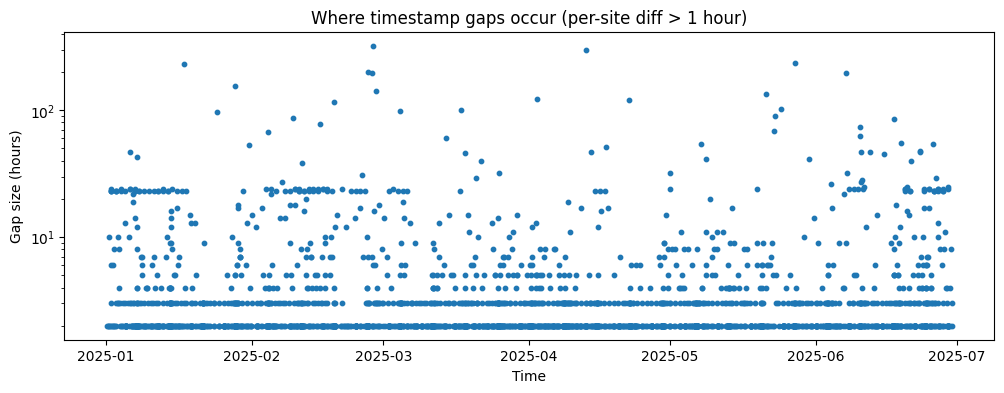

In [256]:
dfp = main_df.sort_values(["SITE_ID", "DATEON"]).copy()

# hours between consecutive rows per site
dfp["gap_hours"] = dfp.groupby("SITE_ID")["DATEON"].diff().dt.total_seconds() / 3600

# keep gaps more than 1 hour jump
gaps = dfp[dfp["gap_hours"] > 1].copy()

plt.figure(figsize=(12,4))
plt.scatter(gaps["DATEON"], gaps["gap_hours"], s=10)
plt.xlabel("Time")
plt.ylabel("Gap size (hours)")
plt.title("Where timestamp gaps occur (per-site diff > 1 hour)")
plt.yscale("log")  
plt.show()

In [257]:
# filter + sort
dfp = main_df[main_df["SITE_ID"].isin(keep_sites)].sort_values(["SITE_ID", "DATEON"]).copy()

# compute gaps
dfp["gap_hours"] = dfp.groupby("SITE_ID")["DATEON"].diff().dt.total_seconds() / 3600
gaps = dfp[dfp["gap_hours"] > 1].copy()

#gap size summaries
gap_stats = (
    gaps.groupby("SITE_ID")
        .agg(
            n_gaps=("gap_hours", "size"),
            max_gap=("gap_hours", "max"),
            mean_gap=("gap_hours", "mean"),
            p95_gap=("gap_hours", lambda x: np.percentile(x, 95)),
            first_gap=("DATEON", "min"),
            last_gap=("DATEON", "max"),
        )
        .reindex(keep_sites) 
)

display(gap_stats.sort_values("n_gaps", ascending=False))
print("Total gaps across keep_sites:", len(gaps))

,n_gaps,max_gap,mean_gap,p95_gap,first_gap,last_gap
SITE_ID,,,,,,
CHE185,199,199.0,4.422111,3.0,2025-01-02 00:00:00,2025-06-30 00:00:00
BVL130,38,24.0,4.473684,23.0,2025-01-02 12:00:00,2025-06-24 11:00:00
DEN417,28,41.0,4.857143,19.3,2025-01-07 16:00:00,2025-06-23 15:00:00
CHA467,27,195.0,9.592593,5.7,2025-01-08 12:00:00,2025-06-25 11:00:00
BEL116,23,67.0,12.260870,45.9,2025-01-14 12:00:00,2025-06-25 15:00:00
GRS420,21,9.0,2.809524,8.0,2025-01-14 15:00:00,2025-06-24 13:00:00


Total gaps across keep_sites: 336


In [258]:
for sid in keep_sites:
    g = gaps[gaps["SITE_ID"] == sid].sort_values("DATEON")[["DATEON", "gap_hours"]]
    print(f"\n{sid}: {len(g)} gaps")
    display(g.head(10))


GRS420: 21 gaps


,DATEON,gap_hours
134130,2025-01-14 15:00:00,2.0
134461,2025-01-28 11:00:00,2.0
134795,2025-02-11 10:00:00,2.0
135131,2025-02-25 11:00:00,2.0
135466,2025-03-11 13:00:00,4.0
135629,2025-03-18 09:00:00,2.0
135796,2025-03-25 09:00:00,2.0
135964,2025-04-01 10:00:00,2.0
136131,2025-04-08 10:00:00,2.0
136298,2025-04-15 10:00:00,2.0



DEN417: 28 gaps


,DATEON,gap_hours
96152,2025-01-07 16:00:00,2.0
96322,2025-01-14 19:00:00,2.0
96995,2025-02-11 21:00:00,2.0
97328,2025-02-25 19:00:00,2.0
97491,2025-03-04 15:00:00,2.0
97824,2025-03-18 13:00:00,2.0
97992,2025-03-25 14:00:00,2.0
98158,2025-04-01 13:00:00,2.0
98834,2025-04-29 19:00:00,3.0
98999,2025-05-06 17:00:00,2.0



BVL130: 38 gaps


,DATEON,gap_hours
33513,2025-01-02 12:00:00,2.0
33563,2025-01-05 02:00:00,13.0
33564,2025-01-06 02:00:00,24.0
33566,2025-01-07 02:00:00,23.0
33568,2025-01-08 02:00:00,23.0
33570,2025-01-08 10:00:00,7.0
33593,2025-01-09 10:00:00,2.0
33714,2025-01-14 12:00:00,2.0
33903,2025-01-22 10:00:00,2.0
34048,2025-01-28 12:00:00,2.0



CHA467: 27 gaps


,DATEON,gap_hours
54837,2025-01-08 12:00:00,3.0
54980,2025-01-14 12:00:00,2.0
55122,2025-01-20 11:00:00,2.0
55146,2025-01-21 13:00:00,3.0
55268,2025-01-26 16:00:00,2.0
55335,2025-01-29 12:00:00,2.0
55621,2025-02-10 11:00:00,2.0
55812,2025-02-26 12:00:00,195.0
55930,2025-03-03 11:00:00,2.0
56122,2025-03-11 12:00:00,2.0



BEL116: 23 gaps


,DATEON,gap_hours
25452,2025-01-14 12:00:00,3.0
25617,2025-01-21 10:00:00,2.0
25784,2025-01-28 11:00:00,3.0
25887,2025-02-04 12:00:00,67.0
25898,2025-02-05 00:00:00,2.0
25915,2025-02-05 18:00:00,2.0
25949,2025-02-07 05:00:00,2.0
26019,2025-02-11 16:00:00,38.0
26154,2025-02-17 13:00:00,7.0
26175,2025-02-18 11:00:00,2.0



CHE185: 199 gaps


,DATEON,gap_hours
62936,2025-01-02 00:00:00,3.0
62958,2025-01-03 00:00:00,3.0
62980,2025-01-04 00:00:00,3.0
63002,2025-01-05 00:00:00,3.0
63024,2025-01-06 00:00:00,3.0
63046,2025-01-07 00:00:00,3.0
63056,2025-01-07 12:00:00,3.0
63066,2025-01-08 00:00:00,3.0
63088,2025-01-09 00:00:00,3.0
63110,2025-01-10 00:00:00,3.0


Dropping BEL116 too as it has large time gaps which are not safe for imputation

In [259]:
keep_sites = ["GRS420","DEN417","BVL130","CHA467","CHE185"]  

df = main_df[main_df["SITE_ID"].isin(keep_sites)].copy()
df = df.sort_values(["SITE_ID", "DATEON"]).reset_index(drop=True)

print("Sites:", df["SITE_ID"].unique())
print("Rows:", df.shape[0])

Sites: <StringArray>
['BVL130', 'CHA467', 'CHE185', 'DEN417', 'GRS420']
Length: 5, dtype: str
Rows: 20414


In [260]:
features = [
    "Temperature","Shelter Temperature","Relative Humidity","Solar Radiation",
    "Wind Speed","Wind Direction","Precipitation","Flow Rate"
]
features_lag = features + [f"Ozone_lag{k}" for k in lags]
target = "Ozone"

limit_hours = 3  # only fill up to 3 consecutive missing time steps

site_name_map = df.groupby("SITE_ID")["SITE_NAME"].first().to_dict()

def interp_site(g):
    sid = g.name                   
    sname = site_name_map.get(sid)

    g = g.sort_values("DATEON").set_index("DATEON")
    g[features] = g[features].interpolate(
        method="time",
        limit=limit_hours,
        limit_direction="both"
    )
    g = g.reset_index()

    g["SITE_ID"] = sid             
    g["SITE_NAME"] = sname
    return g

df_imputed = df.groupby("SITE_ID", group_keys=False).apply(interp_site)

In [261]:
post_missing = df_imputed[features].isna().mean().sort_values(ascending=False)
display((post_missing * 100).round(2).to_frame("% missing after interpolation (limit=3)"))

,% missing after interpolation (limit=3)
Wind Direction,0.47
Wind Speed,0.47
Relative Humidity,0.40
Temperature,0.31
Precipitation,0.31
Solar Radiation,0.31
Shelter Temperature,0.00
Flow Rate,0.00


In [262]:
before = len(df_imputed)
df_clean = df_imputed.dropna(subset=features).copy()
after = len(df_clean)
print(f"Dropped {before-after} rows ({(before-after)/before:.3%}) due to remaining feature NaNs.")

Dropped 112 rows (0.549%) due to remaining feature NaNs.


In [263]:
dfx = df_clean.copy()

Checking for impossible values

In [264]:
checks = {
    "Relative Humidity": (0, 100),
    "Wind Direction": (0, 360),
    "Wind Speed": (0, None),        
    "Precipitation": (0, None),       
    "Solar Radiation": (0, None),     
    "Temperature": (-50, 60),
    "Shelter Temperature": (-50, 60),
    "Ozone": (0, None),              
}

bad_rows = {}
for col, (lo, hi) in checks.items():
    if col not in dfx.columns: 
        continue
    s = dfx[col]
    mask = pd.Series(False, index=dfx.index)
    if lo is not None: mask |= (s < lo)
    if hi is not None: mask |= (s > hi)
    bad_rows[col] = int(mask.sum())

pd.DataFrame.from_dict(bad_rows, orient="index", columns=["# outside hard bounds"]).sort_values(
    "# outside hard bounds", ascending=False
)

,# outside hard bounds
Ozone,4
Relative Humidity,0
Wind Speed,0
Wind Direction,0
Precipitation,0
Solar Radiation,0
Temperature,0
Shelter Temperature,0


In [265]:
features = [
    "Temperature","Shelter Temperature","Relative Humidity","Solar Radiation",
    "Wind Speed","Wind Direction","Precipitation","Flow Rate","Ozone"
]

iqr_counts = {}
for col in features:
    if col not in dfx.columns: 
        continue
    s = dfx[col].dropna()
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lo, hi = q1 - 3*iqr, q3 + 3*iqr   
    iqr_counts[col] = int(((dfx[col] < lo) | (dfx[col] > hi)).sum())

pd.DataFrame.from_dict(iqr_counts, orient="index", columns=["# IQR outliers (3*IQR)"]).sort_values(
    "# IQR outliers (3*IQR)", ascending=False
)

,# IQR outliers (3*IQR)
Precipitation,1050
Wind Speed,30
Solar Radiation,4
Shelter Temperature,2
Temperature,0
Relative Humidity,0
Wind Direction,0
Flow Rate,0
Ozone,0


In [266]:
bad_oz = df_clean[df_clean["Ozone"] < 0][["SITE_ID", "DATEON", "Ozone"]]
print("Bad ozone rows:", len(bad_oz))
display(bad_oz)

Bad ozone rows: 4


,SITE_ID,DATEON,Ozone
87,BVL130,2025-01-06 03:00:00,-0.010
88,BVL130,2025-01-07 02:00:00,-0.022
89,BVL130,2025-01-07 03:00:00,-0.003
91,BVL130,2025-01-08 03:00:00,-0.006


In [267]:
before = len(df_clean)
df_clean = df_clean[df_clean["Ozone"] >= 0].copy()
after = len(df_clean)
print(f"Dropped {before-after} rows with negative ozone.")

Dropped 4 rows with negative ozone.


In [268]:
df_vis = df_clean.copy()
df_vis["DATEON"] = pd.to_datetime(df_vis["DATEON"], errors="coerce")
df_vis = df_vis.sort_values(["SITE_ID", "DATEON"])

## Data Visualization

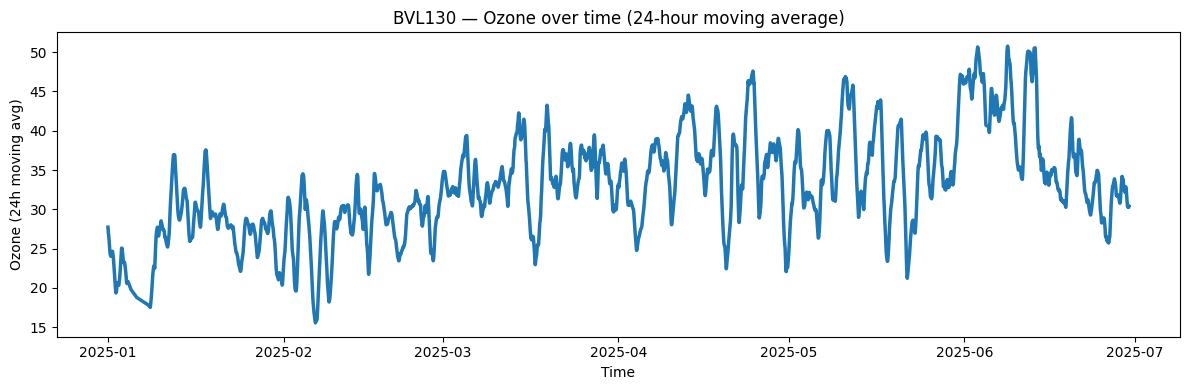

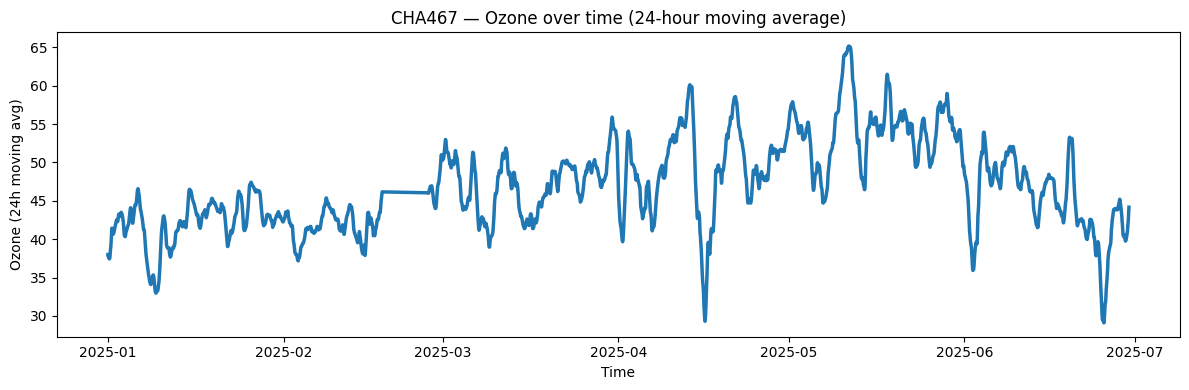

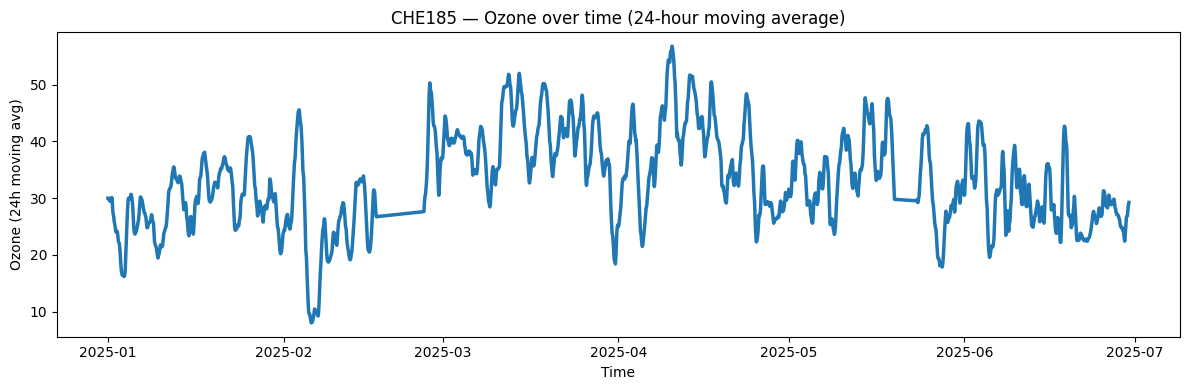

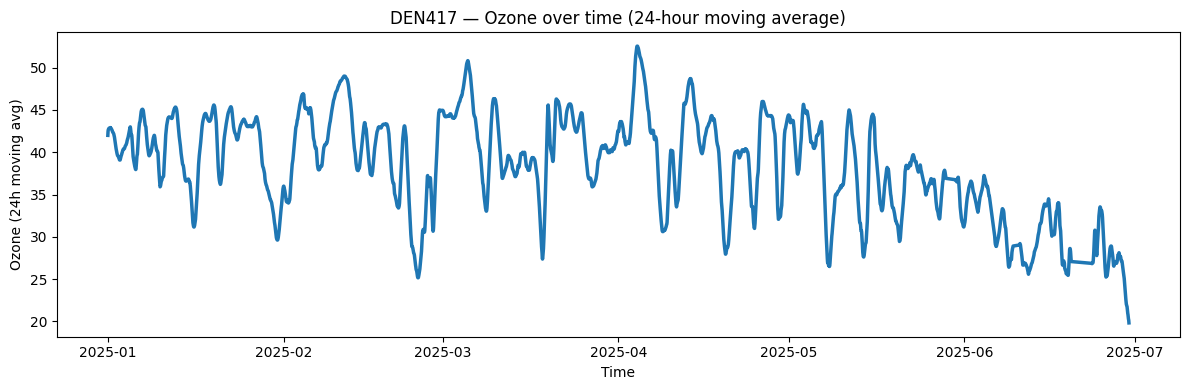

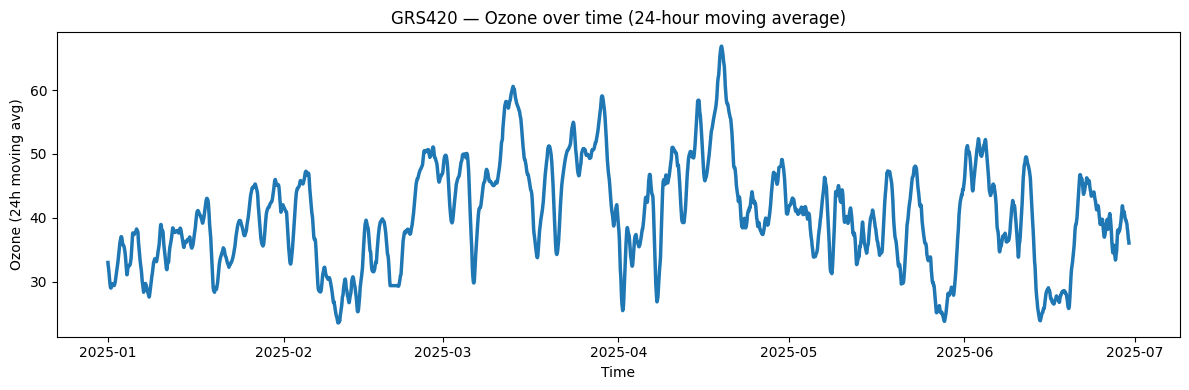

In [269]:
window = 24  # 24-hour moving average 

for sid, g in df_vis.groupby("SITE_ID"):
    g = g.sort_values("DATEON")
    ozone_ma = g["Ozone"].rolling(window=window, min_periods=1).mean()

    plt.figure(figsize=(12,4))
    plt.plot(g["DATEON"], ozone_ma, linewidth=2.5)
    plt.xlabel("Time")
    plt.ylabel(f"Ozone ({window}h moving avg)")
    plt.title(f"{sid} — Ozone over time ({window}-hour moving average)")
    plt.tight_layout()
    plt.show()

These plots shows the 24-hour moving average of ozone for all sites. Smoothing reduces hourly noise and highlights longer-term patterns such as seasonal variation and persistent differences in baseline ozone levels.

C:\Users\prate\AppData\Local\Temp\ipykernel_20776\2972090535.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=sites, showfliers=False)


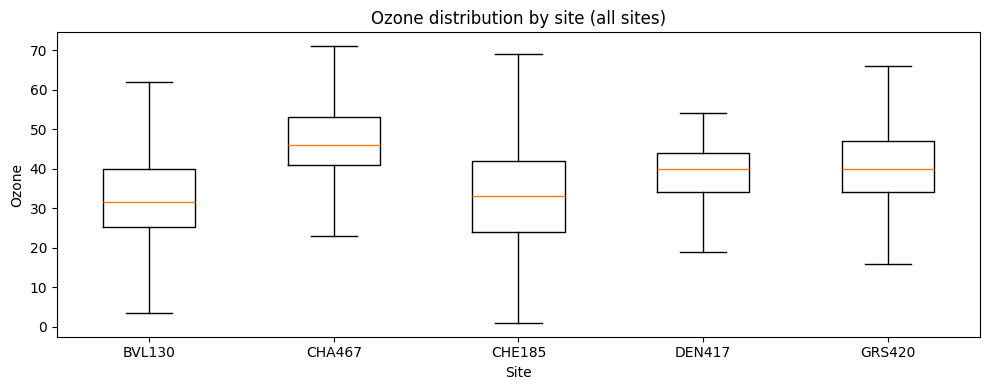

In [270]:
sites = sorted(df_vis["SITE_ID"].unique())
data = [df_vis[df_vis["SITE_ID"] == s]["Ozone"].dropna().to_numpy() for s in sites]

plt.figure(figsize=(10,4))
plt.boxplot(data, labels=sites, showfliers=False)
plt.xlabel("Site")
plt.ylabel("Ozone")
plt.title("Ozone distribution by site (all sites)")
plt.tight_layout()
plt.show()

This plot compares ozone distributions across sites. Differences in medians/spread indicate site-specific environmental conditions and motivate including site information.

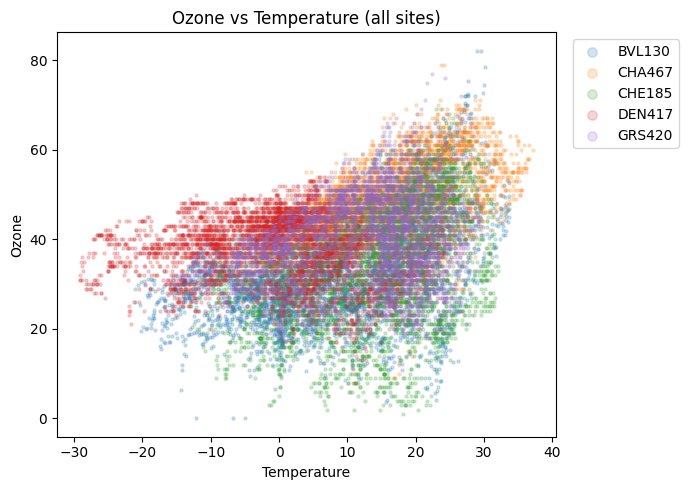

In [271]:
plt.figure(figsize=(7,5))
for sid, g in df_vis.groupby("SITE_ID"):
    plt.scatter(g["Temperature"], g["Ozone"], s=5, alpha=0.2, label=sid)

plt.xlabel("Temperature")
plt.ylabel("Ozone")
plt.title("Ozone vs Temperature (all sites)")
plt.legend(markerscale=3, bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

Across all sites, ozone often shows a positive relationship with temperature. Site-wise clouds of points can have different slopes/offsets, suggesting local factors and transport differences.

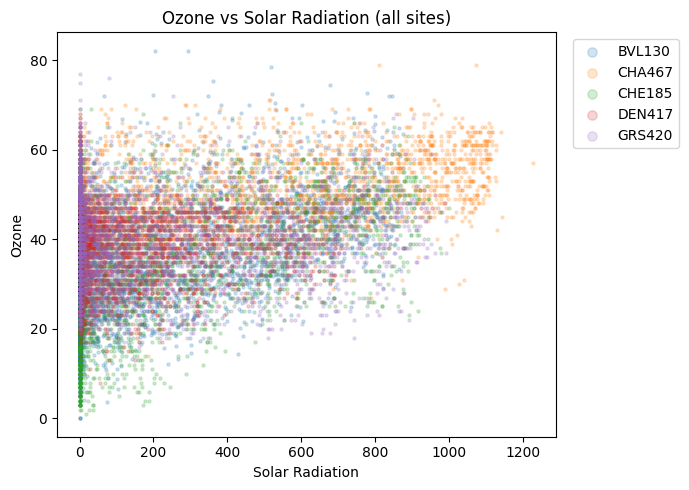

In [272]:
plt.figure(figsize=(7,5))
for sid, g in df_vis.groupby("SITE_ID"):
    plt.scatter(g["Solar Radiation"], g["Ozone"], s=5, alpha=0.2, label=sid)

plt.xlabel("Solar Radiation")
plt.ylabel("Ozone")
plt.title("Ozone vs Solar Radiation (all sites)")
plt.legend(markerscale=3, bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

Solar radiation is a key driver for photochemical ozone formation. If ozone rises with higher solar radiation across sites, it supports using solar radiation as an important predictor feature.

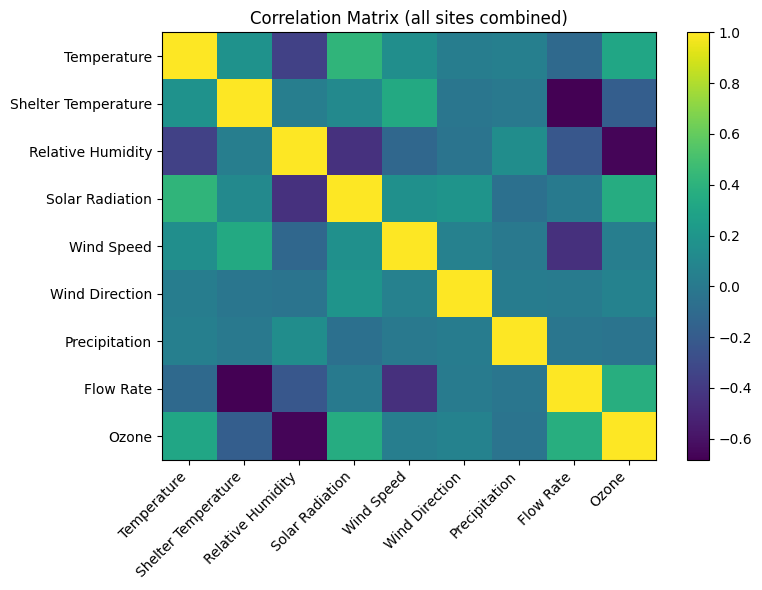

In [273]:
num_cols = [
    "Temperature","Shelter Temperature","Relative Humidity","Solar Radiation",
    "Wind Speed","Wind Direction","Precipitation","Flow Rate","Ozone"
]
corr = df_vis[num_cols].corr(numeric_only=True)

plt.figure(figsize=(8,6))
plt.imshow(corr, aspect="auto")
plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha="right")
plt.yticks(range(len(num_cols)), num_cols)
plt.colorbar()
plt.title("Correlation Matrix (all sites combined)")
plt.tight_layout()
plt.show()

This correlation matrix summarizes global linear relationships across all sites. Expecting ozone to correlate with temperature and solar radiation. Other variables (wind, humidity, precipitation) may show weaker or mixed correlations due to site-specific meteorology.

## Splitting the Data and Normalization

In [274]:
df_model = df_clean.copy()
df_model["DATEON"] = pd.to_datetime(df_model["DATEON"], errors="coerce")
df_model = df_model.sort_values(["SITE_ID", "DATEON"]).reset_index(drop=True)

features = [
    "Temperature","Shelter Temperature","Relative Humidity","Solar Radiation",
    "Wind Speed","Wind Direction","Precipitation","Flow Rate"
]
target = "Ozone"

# Global time split: by date percentiles on DATEON
t1 = df_model["DATEON"].quantile(0.60)
t2 = df_model["DATEON"].quantile(0.80)

train_df = df_model[df_model["DATEON"] <= t1].copy()
val_df   = df_model[(df_model["DATEON"] > t1) & (df_model["DATEON"] <= t2)].copy()
test_df  = df_model[df_model["DATEON"] > t2].copy()

print(len(train_df), len(val_df), len(test_df))
print("Train range:", train_df["DATEON"].min(), "->", train_df["DATEON"].max())
print("Test  range:", test_df["DATEON"].min(),  "->", test_df["DATEON"].max())

12182 4057 4059
Train range: 2025-01-01 00:00:00 -> 2025-04-19 07:00:00
Test  range: 2025-05-24 19:00:00 -> 2025-06-30 00:00:00


Using Z-score normalization

In [275]:
mu = train_df[features].mean()
std = train_df[features].std().replace(0, 1) 

def apply_zscore(df_):
    df_ = df_.copy()
    df_[features] = (df_[features] - mu) / std
    return df_

train_df_n = apply_zscore(train_df)
val_df_n   = apply_zscore(val_df)
test_df_n  = apply_zscore(test_df)

In [312]:
def add_ozone_lags(df_split, lags=(1,2,3)):
    df_split = df_split.sort_values(["SITE_ID", "DATEON"]).copy()
    for k in lags:
        df_split[f"Ozone_lag{k}"] = df_split.groupby("SITE_ID")["Ozone"].shift(k)
    return df_split

lags = (1, 2, 3, 24)

train_df_l = add_ozone_lags(train_df_n, lags=lags)
val_df_l   = add_ozone_lags(val_df_n,   lags=lags)
test_df_l  = add_ozone_lags(test_df_n,  lags=lags)

In [313]:
print("Train means:")
print(train_df_n[features].mean().round(3))

print("\nTrain stds::")
print(train_df_n[features].std().round(3))

Train means:
Temperature           -0.0
Shelter Temperature   -0.0
Relative Humidity      0.0
Solar Radiation       -0.0
Wind Speed             0.0
Wind Direction        -0.0
Precipitation         -0.0
Flow Rate             -0.0
dtype: float64

Train stds::
Temperature            1.0
Shelter Temperature    1.0
Relative Humidity      1.0
Solar Radiation        1.0
Wind Speed             1.0
Wind Direction         1.0
Precipitation          1.0
Flow Rate              1.0
dtype: float64


Building windows as it is the appropriate method for the Neural Network to analyze time series datas

In [314]:
def make_windows(df_split, features, target, L=48, H=1):
    X_list, y_list = [], []
    for _, g in df_split.groupby("SITE_ID", sort=False):
        g = g.sort_values("DATEON").dropna(subset=features + [target]).reset_index(drop=True)
        Xv = g[features].to_numpy()
        yv = g[target].to_numpy()
        n = len(g)

        for end in range(L-1, n - H):
            start = end - (L - 1)
            X_list.append(Xv[start:end+1])   # length L
            y_list.append(yv[end + H])       # predict H steps after end

    X = np.stack(X_list) if X_list else np.empty((0, L, len(features)))
    y = np.array(y_list) if y_list else np.empty((0,))
    return X, y

In [315]:
L = 48
H = 1

X_train, y_train = make_windows(train_df_l, features_lag, target, L=L, H=H)
X_validation, y_validation = make_windows(val_df_l, features_lag, target, L=L, H=H)
X_test, y_test = make_windows(test_df_l, features_lag, target, L=L, H=H)


In [316]:
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_validation:", X_validation.shape, "y_validation:", y_validation.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

X_train: (11927, 48, 11) y_train: (11927,)
X_validation: (3802, 48, 11) y_validation: (3802,)
X_test: (3804, 48, 11) y_test: (3804,)


In [317]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [318]:
class OzoneDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [319]:
batch_size = 256

train_loader = DataLoader(OzoneDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(OzoneDataset(X_validation, y_validation), batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(OzoneDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

## Step - 2: NN Model

Using 3 NN models for this forecasting problem. For time series data, LSTM and GRU NN models are popular choices. I have also included a custom Multi-Layer Perceptron.

Custom Model:

In [391]:
class MLPWindowRegressor(nn.Module):
    def __init__(self, L, F, hidden=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(L * F, hidden),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden, hidden // 2),
            nn.ReLU(),
            nn.Linear(hidden // 2, 1),
        )

    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        return self.net(x).squeeze(-1)
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

L = X_train.shape[1]         
F = X_train.shape[2]          

mlp_model  = MLPWindowRegressor(L=L, F=F, hidden=128).to(device)

print(mlp_model)


MLPWindowRegressor(
  (net): Sequential(
    (0): Linear(in_features=528, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=1, bias=True)
  )
)


Custom Neural Network Model:

A 2-hidden layer or a 3 layer Neural Network model was created for this problem. There are 128 nodes in the first hidden layer and 64 nodes in the second hidden layer. The input shape of 528 nodes is due to the lookback of 48 hours. Since ozone data would not reveal any pattents on a short-term hourly basis, a lookback has been used to provide larger picture to the Neural Network. The activation function used is ReLU.

GRU Model:

In [392]:
class GRURegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1, dropout=0.0):
        super().__init__()
        self.gru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.head = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        # x: (B, L, F)
        out, _ = self.gru(x)          # out: (B, L, H)
        last = out[:, -1, :]          # last timestep
        yhat = self.head(last).squeeze(-1)  # (B,)
        return yhat
    

gru_model  = GRURegressor(input_dim=F, hidden_dim=64, num_layers=1).to(device)

print(gru_model)

GRURegressor(
  (gru): GRU(11, 64, batch_first=True)
  (head): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)


LSTM Model:

In [393]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1, dropout=0.0):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.head = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        out, _ = self.lstm(x)          # out: (B, L, H)
        last = out[:, -1, :]
        return self.head(last).squeeze(-1)
    

lstm_model = LSTMRegressor(input_dim=F, hidden_dim=64, num_layers=1).to(device)

print(lstm_model)

LSTMRegressor(
  (lstm): LSTM(11, 64, batch_first=True)
  (head): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)


Setting up evaluation methods: Since the problem here is a regression problem, r2 score and tolerance accuracy were used to validate the results

In [394]:

def r2_score_np(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1.0 - ss_res / (ss_tot + 1e-12)

def tolerance_accuracy(y_true, y_pred, tolerance=0.10, eps=1e-8):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    accurate = (np.abs(y_true - y_pred) <= tolerance * np.maximum(np.abs(y_true), eps))
    return accurate.mean() * 100

Training Pipeline:

In [395]:

def run_epoch(model, loader, criterion, optimizer=None, device="cpu"):
    train = optimizer is not None
    model.train(train)

    total_loss = 0.0
    n = 0

    for Xb, yb in loader:
        Xb = Xb.to(device)
        yb = yb.to(device)

        if train:
            optimizer.zero_grad()

        preds = model(Xb)
        loss = criterion(preds, yb)

        if train:
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * Xb.size(0)
        n += Xb.size(0)

    return total_loss / max(n, 1)


def train_model(model, train_loader, val_loader, epochs=10, lr=1e-3,
                             weight_decay=0.0, device="cpu", model_name="MODEL",
                             tol=0.15):
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    history = {
        "epoch": [],
        "train_mse": [],
        "val_mse": [],
        "val_r2": [],
        "val_acc": [],
        "epoch_time_s": [],
        "cum_time_s": []
    }

    best_val = float("inf")
    best_state = None

    t0 = time.perf_counter()
    for ep in range(1, epochs + 1):
        ep_t0 = time.perf_counter()

        tr = run_epoch(model, train_loader, criterion, optimizer=optimizer, device=device)
        va = run_epoch(model, val_loader, criterion, optimizer=None, device=device)

        # compute val R2 + tol-accuracy (uses your existing predict_all + metrics)
        y_pred_val, y_true_val = predict_all(model, val_loader, device=device)
        r2 = float(r2_score_np(y_true_val, y_pred_val))
        acc = float(tolerance_accuracy(y_true_val, y_pred_val, tolerance=tol))

        ep_dt = time.perf_counter() - ep_t0
        cum_dt = time.perf_counter() - t0

        history["epoch"].append(ep)
        history["train_mse"].append(tr)
        history["val_mse"].append(va)
        history["val_r2"].append(r2)
        history["val_acc"].append(acc)
        history["epoch_time_s"].append(ep_dt)
        history["cum_time_s"].append(cum_dt)

        if va < best_val:
            best_val = va
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        print(f"{model_name} | Ep {ep:02d}/{epochs} | train MSE {tr:.4f} | val MSE {va:.4f} | val Acc@{int(tol*100)}% {acc:.2f}% | time {ep_dt:.2f}s")

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, history


Training all 3 models

In [396]:
EPOCHS = 100
LR = 1e-3
WD = 1e-4
TOL = 0.15

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("torch:", torch.__version__)
print("device:", device)

print("=== MLP ===")
mlp_model, hist_mlp = train_model(mlp_model, train_loader, val_loader, epochs=EPOCHS, lr=LR, device=device, model_name="MLP",  tol=TOL)

torch: 2.10.0+cu128
device: cuda
=== MLP ===
MLP | Ep 01/100 | train MSE 159.4885 | val MSE 80.5849 | val Acc@15% 56.23% | time 0.31s
MLP | Ep 02/100 | train MSE 47.1162 | val MSE 58.3345 | val Acc@15% 62.23% | time 0.37s
MLP | Ep 03/100 | train MSE 36.9543 | val MSE 48.5692 | val Acc@15% 66.62% | time 0.29s
MLP | Ep 04/100 | train MSE 31.7498 | val MSE 47.4909 | val Acc@15% 65.99% | time 0.30s
MLP | Ep 05/100 | train MSE 28.9418 | val MSE 40.4948 | val Acc@15% 70.09% | time 0.29s
MLP | Ep 06/100 | train MSE 26.6426 | val MSE 38.3478 | val Acc@15% 71.54% | time 0.31s
MLP | Ep 07/100 | train MSE 24.7931 | val MSE 40.2751 | val Acc@15% 70.99% | time 0.30s
MLP | Ep 08/100 | train MSE 23.6110 | val MSE 35.8899 | val Acc@15% 73.75% | time 0.21s
MLP | Ep 09/100 | train MSE 23.0680 | val MSE 32.8940 | val Acc@15% 75.04% | time 0.26s
MLP | Ep 10/100 | train MSE 21.8875 | val MSE 33.2337 | val Acc@15% 75.17% | time 0.29s
MLP | Ep 11/100 | train MSE 20.8205 | val MSE 30.7601 | val Acc@15% 76.54%

Evaluating MLP

In [397]:
@torch.no_grad()
def predict_all(model, loader, device="cpu"):
    model.eval()
    preds_all, y_all = [], []
    for Xb, yb in loader:
        Xb = Xb.to(device)
        preds = model(Xb).cpu().numpy()
        preds_all.append(preds)
        y_all.append(yb.numpy())
    return np.concatenate(preds_all), np.concatenate(y_all)

In [398]:
def eval_model(model, loader, device, tol=0.15):
    t0 = time.perf_counter()
    y_pred, y_true = predict_all(model, loader, device=device)
    eval_time = time.perf_counter() - t0

    mse = float(np.mean((y_true - y_pred)**2))
    r2  = float(r2_score_np(y_true, y_pred))
    acc = float(tolerance_accuracy(y_true, y_pred, tolerance=tol))
    return {"mse": mse, "r2": r2, "acc": acc, "eval_time": eval_time,
            "y_true": y_true, "y_pred": y_pred}

Defining a prediction as accurate if it falls within ±15% of the true ozone value (tolerance = 0.15). This choice balances strictness with the natural variability in hourly ozone measurements. However, checking against lower as well as higher tolerance for a frame of reference.

In [399]:
tol_list = [0.10, 0.12, 0.15, 0.20]

def report_split(model, loader, split_name, model_name="MODEL"):
    y_pred, y_true = predict_all(model, loader, device=device)
    r2 = r2_score_np(y_true, y_pred)
    print(f"\n{model_name} | {split_name} | R2: {r2:.4f}")
    for t in tol_list:
        acc = tolerance_accuracy(y_true, y_pred, tolerance=t)
        print(f"Tol {int(t*100)}% -> {acc:.2f}%")

report_split(mlp_model, val_loader,  "Validation", model_name="MLP")
report_split(mlp_model, test_loader, "Test", model_name="MLP")



MLP | Validation | R2: 0.8524
Tol 10% -> 68.36%
Tol 12% -> 75.59%
Tol 15% -> 82.90%
Tol 20% -> 89.69%

MLP | Test | R2: 0.8427
Tol 10% -> 61.09%
Tol 12% -> 68.56%
Tol 15% -> 77.13%
Tol 20% -> 84.91%


In [400]:
torch.save(mlp_model.state_dict(), "mlp_weights.pkl")
print("Saved MLP weights to mlp_weights.pkl")

Saved MLP weights to mlp_weights.pkl


In [401]:
def split_site_counts(df_split, name):
    print(f"\n{name} rows per site:")
    display(df_split["SITE_ID"].value_counts())

split_site_counts(train_df_n, "TRAIN")
split_site_counts(val_df_n, "VAL")
split_site_counts(test_df_n, "TEST")


TRAIN rows per site:


SITE_ID
DEN417    2592
GRS420    2557
BVL130    2477
CHA467    2384
CHE185    2172
Name: count, dtype: int64


VAL rows per site:


SITE_ID
DEN417    848
BVL130    846
CHA467    842
GRS420    831
CHE185    690
Name: count, dtype: int64


TEST rows per site:


SITE_ID
GRS420    864
CHA467    863
BVL130    845
CHE185    778
DEN417    709
Name: count, dtype: int64

Comparing Results with Baseline Models

In [402]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

F = X_train.shape[2]  # number of features (including ozone lags)

gru_model  = GRURegressor(input_dim=F, hidden_dim=64, num_layers=1).to(device)
lstm_model = LSTMRegressor(input_dim=F, hidden_dim=64, num_layers=1).to(device)

device: cuda


In [403]:
EPOCHS = 100
LR = 1e-3
WD = 1e-4
TOL = 0.15

print("=== GRU ===")
gru_model,  hist_gru  = train_model(gru_model,  train_loader, val_loader, epochs=EPOCHS, lr=LR, weight_decay=WD, device=device, model_name="GRU",  tol=TOL)

print("\n=== LSTM ===")
lstm_model, hist_lstm = train_model(lstm_model, train_loader, val_loader, epochs=EPOCHS, lr=LR, weight_decay=WD, device=device, model_name="LSTM", tol=TOL)

=== GRU ===
GRU | Ep 01/100 | train MSE 1336.7832 | val MSE 1107.0087 | val Acc@15% 0.39% | time 0.36s
GRU | Ep 02/100 | train MSE 527.5733 | val MSE 259.3198 | val Acc@15% 18.91% | time 0.25s
GRU | Ep 03/100 | train MSE 103.2509 | val MSE 90.9170 | val Acc@15% 52.95% | time 0.26s
GRU | Ep 04/100 | train MSE 30.8251 | val MSE 45.6868 | val Acc@15% 70.83% | time 0.29s
GRU | Ep 05/100 | train MSE 17.8322 | val MSE 33.9069 | val Acc@15% 75.36% | time 0.23s
GRU | Ep 06/100 | train MSE 14.4591 | val MSE 28.5372 | val Acc@15% 78.77% | time 0.28s
GRU | Ep 07/100 | train MSE 12.9990 | val MSE 25.8322 | val Acc@15% 80.75% | time 0.33s
GRU | Ep 08/100 | train MSE 12.2674 | val MSE 24.0161 | val Acc@15% 82.14% | time 0.32s
GRU | Ep 09/100 | train MSE 11.5180 | val MSE 22.8742 | val Acc@15% 82.56% | time 0.31s
GRU | Ep 10/100 | train MSE 11.2410 | val MSE 21.8815 | val Acc@15% 83.01% | time 0.26s
GRU | Ep 11/100 | train MSE 10.8467 | val MSE 21.0909 | val Acc@15% 83.38% | time 0.31s
GRU | Ep 12/10

In [404]:
report_split(gru_model, val_loader,  "Validation", model_name="GRU")
report_split(gru_model, test_loader, "Test", model_name="GRU")
report_split(lstm_model, val_loader,  "Validation", model_name="LSTM")
report_split(lstm_model, test_loader, "Test", model_name="LSTM")


GRU | Validation | R2: 0.8815
Tol 10% -> 73.38%
Tol 12% -> 79.22%
Tol 15% -> 85.32%
Tol 20% -> 90.72%

GRU | Test | R2: 0.8574
Tol 10% -> 62.01%
Tol 12% -> 69.30%
Tol 15% -> 76.21%
Tol 20% -> 85.02%

LSTM | Validation | R2: 0.8797
Tol 10% -> 73.36%
Tol 12% -> 78.96%
Tol 15% -> 84.61%
Tol 20% -> 90.58%

LSTM | Test | R2: 0.8479
Tol 10% -> 61.04%
Tol 12% -> 68.09%
Tol 15% -> 75.55%
Tol 20% -> 83.78%


As observed above, results obtained from MLP are comparable to results from baseline time-series specialized models such as GRU and LSTM

Comparing Results:

In [405]:
TOL = 0.15  # official accuracy tolerance

mlp_res  = eval_model(mlp_model,  test_loader, device, tol=TOL)
gru_res  = eval_model(gru_model,  test_loader, device, tol=TOL)
lstm_res = eval_model(lstm_model, test_loader, device, tol=TOL)

df_compare = pd.DataFrame([
    {"Model":"MLP",  "Test_MSE": mlp_res["mse"],  "Test_R2": mlp_res["r2"],  f"Acc@{int(TOL*100)}%": mlp_res["acc"],
     "Train_time_s": mlp_train_time,  "Eval_time_s": mlp_res["eval_time"]},
    {"Model":"GRU",  "Test_MSE": gru_res["mse"],  "Test_R2": gru_res["r2"],  f"Acc@{int(TOL*100)}%": gru_res["acc"],
     "Train_time_s": gru_train_time,  "Eval_time_s": gru_res["eval_time"]},
    {"Model":"LSTM", "Test_MSE": lstm_res["mse"], "Test_R2": lstm_res["r2"], f"Acc@{int(TOL*100)}%": lstm_res["acc"],
     "Train_time_s": lstm_train_time, "Eval_time_s": lstm_res["eval_time"]},
]).sort_values(by=f"Acc@{int(TOL*100)}%", ascending=False)

df_compare

,Model,Test_MSE,Test_R2,Acc@15%,Train_time_s,Eval_time_s
0,MLP,25.654175,0.842748,77.129338,20.924714,0.030687
1,GRU,23.258730,0.857431,76.209253,24.186359,0.030584
2,LSTM,24.815367,0.847889,75.552050,25.119709,0.027961


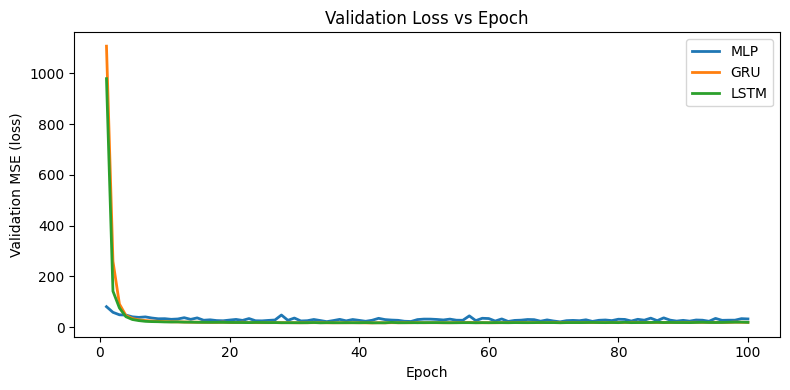

In [406]:
plt.figure(figsize=(8,4))
plt.plot(hist_mlp["epoch"],  hist_mlp["val_mse"],  linewidth=2, label="MLP")
plt.plot(hist_gru["epoch"],  hist_gru["val_mse"],  linewidth=2, label="GRU")
plt.plot(hist_lstm["epoch"], hist_lstm["val_mse"], linewidth=2, label="LSTM")
plt.xlabel("Epoch")
plt.ylabel("Validation MSE (loss)")
plt.title("Validation Loss vs Epoch")
plt.legend()
plt.tight_layout()
plt.show()

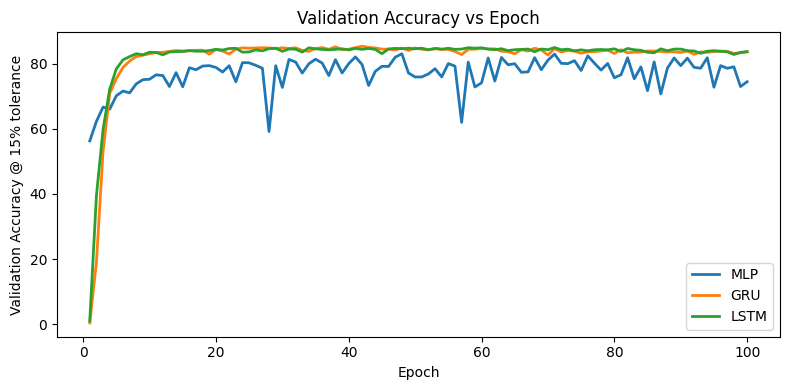

In [407]:
plt.figure(figsize=(8,4))
plt.plot(hist_mlp["epoch"],  hist_mlp["val_acc"],  linewidth=2, label="MLP")
plt.plot(hist_gru["epoch"],  hist_gru["val_acc"],  linewidth=2, label="GRU")
plt.plot(hist_lstm["epoch"], hist_lstm["val_acc"], linewidth=2, label="LSTM")
plt.xlabel("Epoch")
plt.ylabel(f"Validation Accuracy @ {int(TOL*100)}% tolerance")
plt.title("Validation Accuracy vs Epoch")
plt.legend()
plt.tight_layout()
plt.show()

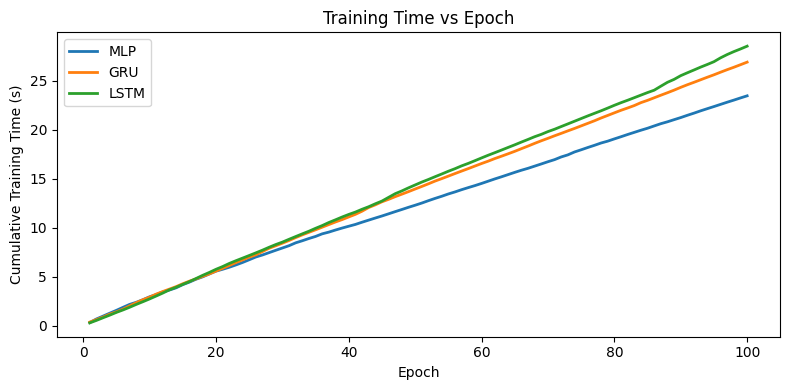

In [408]:
plt.figure(figsize=(8,4))
plt.plot(hist_mlp["epoch"],  hist_mlp["cum_time_s"],  linewidth=2, label="MLP")
plt.plot(hist_gru["epoch"],  hist_gru["cum_time_s"],  linewidth=2, label="GRU")
plt.plot(hist_lstm["epoch"], hist_lstm["cum_time_s"], linewidth=2, label="LSTM")
plt.xlabel("Epoch")
plt.ylabel("Cumulative Training Time (s)")
plt.title("Training Time vs Epoch")
plt.legend()
plt.tight_layout()
plt.show()

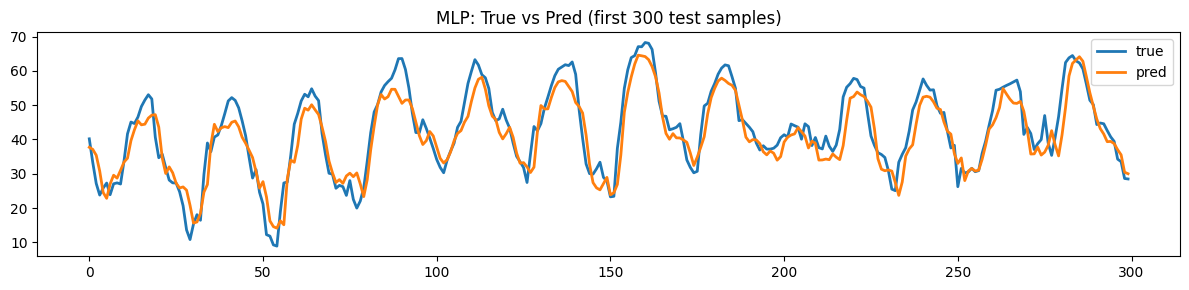

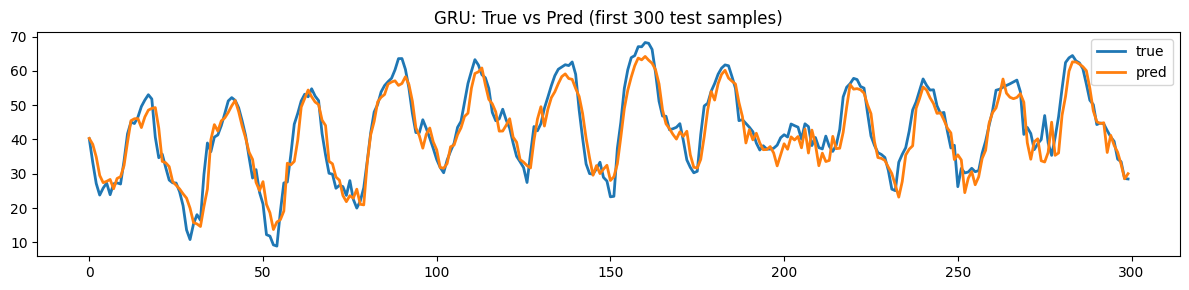

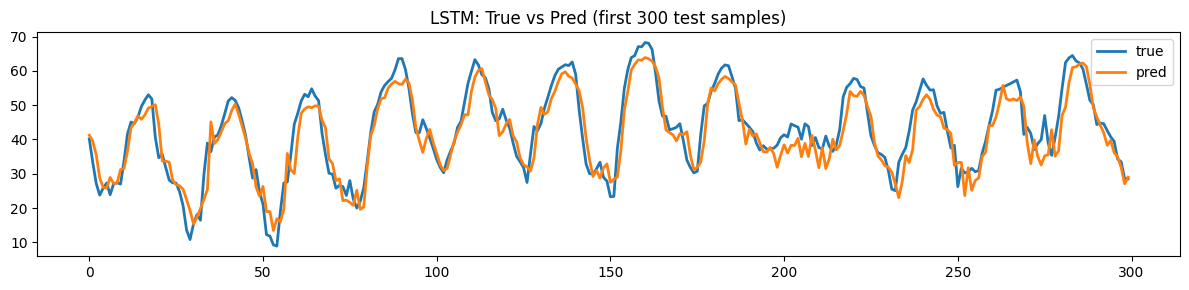

In [409]:
def plot_first_n(y_true, y_pred, title, n=300):
    plt.figure(figsize=(12,3))
    plt.plot(y_true[:n], label="true", linewidth=2)
    plt.plot(y_pred[:n], label="pred", linewidth=2)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_first_n(mlp_res["y_true"],  mlp_res["y_pred"],  "MLP: True vs Pred (first 300 test samples)")
plot_first_n(gru_res["y_true"],  gru_res["y_pred"],  "GRU: True vs Pred (first 300 test samples)")
plot_first_n(lstm_res["y_true"], lstm_res["y_pred"], "LSTM: True vs Pred (first 300 test samples)")

In conclusion, I would like to say that this problem statement of predicting Ozone concentration for time (t+k) could serve as a prototype for ozone concentration forecasting, enabling preventive and corrective measures pre-meditatively. Due to sparsity of complete data in this case, achieving significant accuracy and scale-up of prediction windows were limited but with more advanced data recording techniques, this application holds meaningful and valuable implications

## References: 

https://medium.com/@mrabet_zakariae/forecasting-time-series-with-multilayer-perceptrons-in-python-c7441bda5b59

https://medium.com/@anishnama20/understanding-gated-recurrent-unit-gru-in-deep-learning-2e54923f3e2

https://developer.nvidia.com/discover/lstm

https://encord.com/blog/time-series-predictions-with-recurrent-neural-networks/

https://data.gov/

https://catalog.data.gov/dataset/clean-air-status-and-trends-network-castnet-download-data-module


https://www.epa.gov/castnet/castnet-site-locations


https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html


https://docs.pytorch.org/tutorials/beginner/saving_loading_models.html


https://docs.python.org/3/library/time.html